In [17]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [36]:
# download data using Yahoo finance API
df = yf.download('TSLA').reset_index()
df = df[(df['Date'] >= "2012-01-01") & (df['Date'] <= "2023-03-12")].reset_index(drop=True)
df.head(10)

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,1.929333,1.966667,1.843333,1.872000,1.872000,13921500
1,2012-01-04,1.880667,1.911333,1.833333,1.847333,1.847333,9451500
2,2012-01-05,1.850667,1.862000,1.790000,1.808000,1.808000,15082500
3,2012-01-06,1.813333,1.852667,1.760667,1.794000,1.794000,14794500
4,2012-01-09,1.800000,1.832667,1.741333,1.816667,1.816667,13455000
5,2012-01-10,1.829333,1.850667,1.816667,1.841333,1.841333,10077000
6,2012-01-11,1.841333,1.892000,1.820000,1.882000,1.882000,10084500
7,2012-01-12,1.898667,1.908000,1.854000,1.883333,1.883333,10939500
8,2012-01-13,1.893333,1.900000,1.509333,1.519333,1.519333,82506000
9,2012-01-17,1.774667,1.822667,1.760667,1.773333,1.773333,69774000


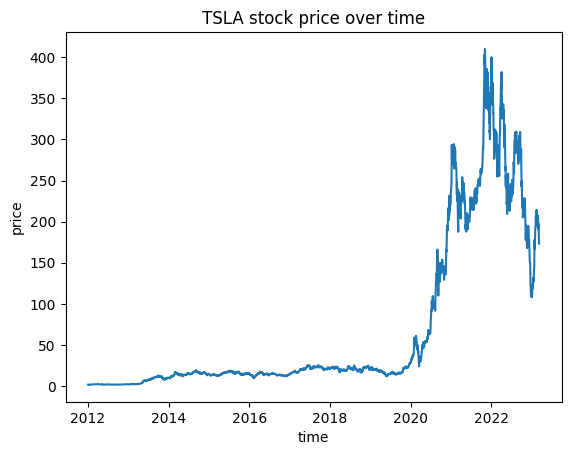

In [37]:
# plot closing price over time
plt.plot(df["Date"], df["Adj Close"])
plt.title("TSLA stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

In [38]:
# scaling the closing price
scaler = MinMaxScaler(feature_range=(0,1))
df['scaled_values'] = scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))

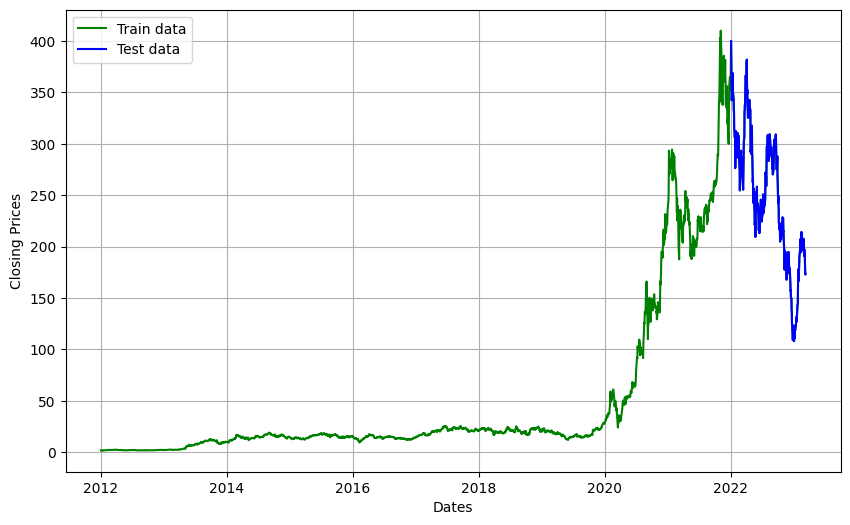

In [39]:
# split data into train and training set
train_data = df[df['Date'] < '2022-01-01']
test_data = df[df['Date'] >= '2022-01-01']

# plotting the data
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df['Date'], df['Adj Close'], 'green', label='Train data')
plt.plot(test_data['Date'], test_data['Adj Close'], 'blue', label='Test data')
plt.legend()

In [40]:
x_train = []
y_train = []

for i in range(60, len(train_data['scaled_values'])):
    x_train.append(train_data['scaled_values'][i-60:i])
    y_train.append(train_data['scaled_values'][i])

x_train, y_train = np.array(x_train), np.array(y_train)

# converting it back to 3D array as required by LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [41]:
x_test = []
y_test = test_data['scaled_values']

for i in range(60, len(test_data)):
    x_test.append(test_data['scaled_values'][i-60:i])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [42]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [43]:
# define model architecture

# Initialize model
model = Sequential()

# LSTM layer 1
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.25))

# LSTM layer 2
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

# LSTM layer 3
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

# LSTM layer 4
model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# final layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_8 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

In [44]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
77/77 [==============================] - 20s 153ms/step - loss: 0.0061
Epoch 2/10
77/77 [==============================] - 13s 165ms/step - loss: 0.0023
Epoch 3/10
77/77 [==============================] - 11s 145ms/step - loss: 0.0016
Epoch 4/10
77/77 [==============================] - 11s 142ms/step - loss: 0.0014
Epoch 5/10
77/77 [==============================] - 9s 123ms/step - loss: 0.0014
Epoch 6/10
77/77 [==============================] - 10s 133ms/step - loss: 0.0013
Epoch 7/10
77/77 [==============================] - 11s 138ms/step - loss: 0.0014
Epoch 8/10
77/77 [==============================] - 10s 137ms/step - loss: 0.0014
Epoch 9/10
77/77 [==============================] - 11s 137ms/step - loss: 0.0015
Epoch 10/10
77/77 [==============================] - 11s 149ms/step - loss: 0.0012


In [45]:
# predict on test data
predicted_stock_price = model.predict(x_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

8/8 [==============================] - 2s 34ms/step


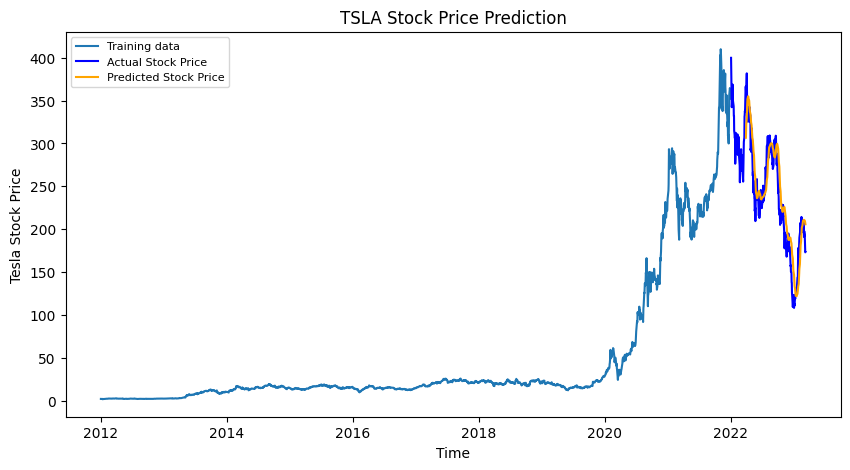

In [47]:
# plot all the series together
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data['Date'], train_data['Close'], label='Training data')
plt.plot(test_data['Date'], test_data['Close'], color = 'blue', label='Actual Stock Price')
plt.plot(test_data[60:]['Date'], predicted_stock_price, color = 'orange',label='Predicted Stock Price')

plt.title('TSLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [48]:
from sklearn.metrics import mean_absolute_error
import math

y_true = test_data[60:]['Close'].values
y_pred = predicted_stock_price

# report performance
mse = mean_squared_error(y_true, y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_true, y_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
print('MAPE: '+str(mape))

MSE: 627.3125728608668
MAE: 20.247286179486444
RMSE: 25.04620875224166
MAPE: 0.3360472534352642
